In [2]:
%load_ext autoreload
%autoreload 2

# Setup


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from gensim.models import KeyedVectors
from modules.nlp import NLP
from modules.visualisation import Visualisation

DATA_DIR = Path().cwd() / 'data'
EMBEDDINGS_DIR = Path().cwd() / 'embeddings'

nlp = NLP()
vis = Visualisation()

# Text preprocessing

In [2]:
posts_df = pd.read_csv(DATA_DIR / 'reddit_parenting_combined.csv')

# Remove posts with no text
posts_df.dropna(subset='selftext', inplace=True)

# Tokenize text and remove stopwords
tqdm.pandas(desc='Tokenizing Reddit text')
posts_df['tokens'] = posts_df['selftext'].progress_apply(
    nlp.tokenize_text)

# Drop empty token cells
posts_df.dropna(subset=['tokens'], inplace=True)

Tokenizing Reddit text: 100%|██████████| 6782/6782 [00:04<00:00, 1360.60it/s]


# Terms in common across all subreddits

In [3]:
# Group texts by subreddit
texts_by_subreddit = {
    subreddit: group['tokens'].tolist()
    for subreddit, group in posts_df.groupby('subreddit')
}

# Generate tf-idf matrices and terms
subreddit_data = {
    subreddit: nlp.generate_tfidf_matrix(texts)
    for subreddit, texts in texts_by_subreddit.items()
}
# Extract vocabularies
vocabularies = [set(terms) for _, terms in subreddit_data.values()]

# Find common terms across all subreddits
common_terms = set.intersection(*vocabularies)

# Create mean tf-idf dataframes for each subreddit
tfidf_dfs = []
for subreddit, (tfidf_matrix, terms) in subreddit_data.items():
    mean_tfidf_matrix = tfidf_matrix.mean(axis=0)
    mean_tfidf_df = pd.DataFrame(
        mean_tfidf_matrix.T,
        index=terms,
        columns=[subreddit]
    ).loc[list(common_terms)]
    tfidf_dfs.append(mean_tfidf_df)

# Concatenate mean tf-idf dataframes
common_terms_df = pd.concat(tfidf_dfs, axis=1)

# Calculate an average tf-idf score for each term
common_terms_df['mean_tfidf'] = common_terms_df.mean(axis=1)

# Sort terms by average tf-idf score
common_terms_df.sort_values('mean_tfidf', ascending=False, inplace=True)
common_terms_df.head(10)

,CatholicParenting,MuslimParenting,Parenting,atheistparents,mean_tfidf
kids,0.022388,0.036421,0.035067,0.034820,0.032174
like,0.025088,0.029110,0.035937,0.031894,0.030507
would,0.020664,0.026714,0.026316,0.031146,0.026210
want,0.021517,0.025339,0.024096,0.030932,0.025471
know,0.023287,0.021746,0.028081,0.025578,0.024673
time,0.025295,0.022076,0.031527,0.018099,0.024249
children,0.027874,0.030104,0.012901,0.022185,0.023266
one,0.025298,0.018920,0.024250,0.022192,0.022665
child,0.019234,0.027189,0.020491,0.021565,0.022120
parents,0.015408,0.029433,0.019276,0.023327,0.021861


## Plotting word similarities using t-SNE

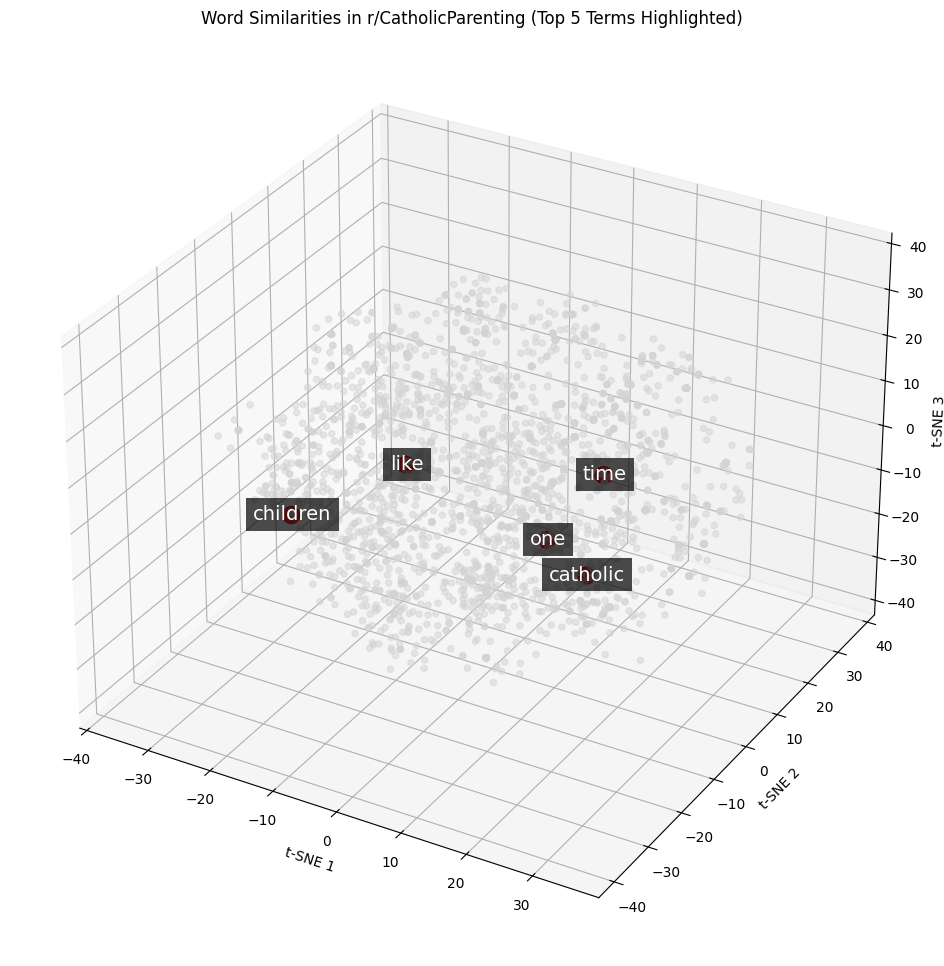

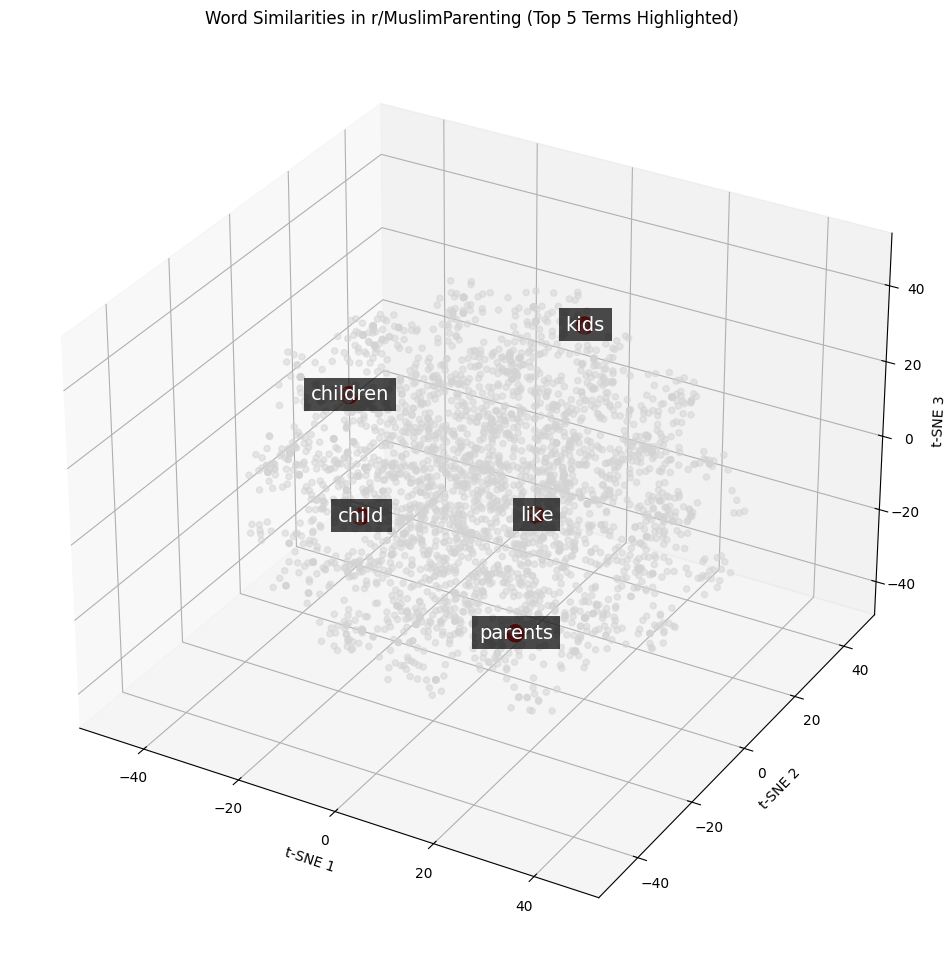

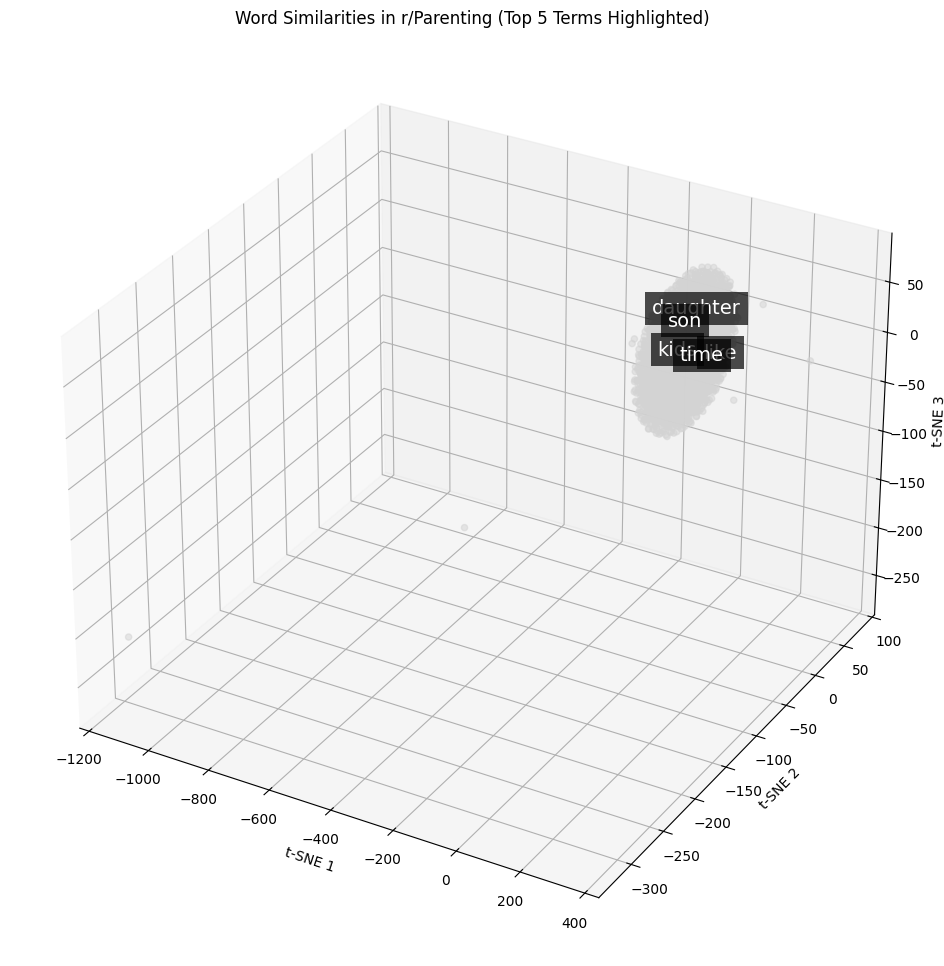

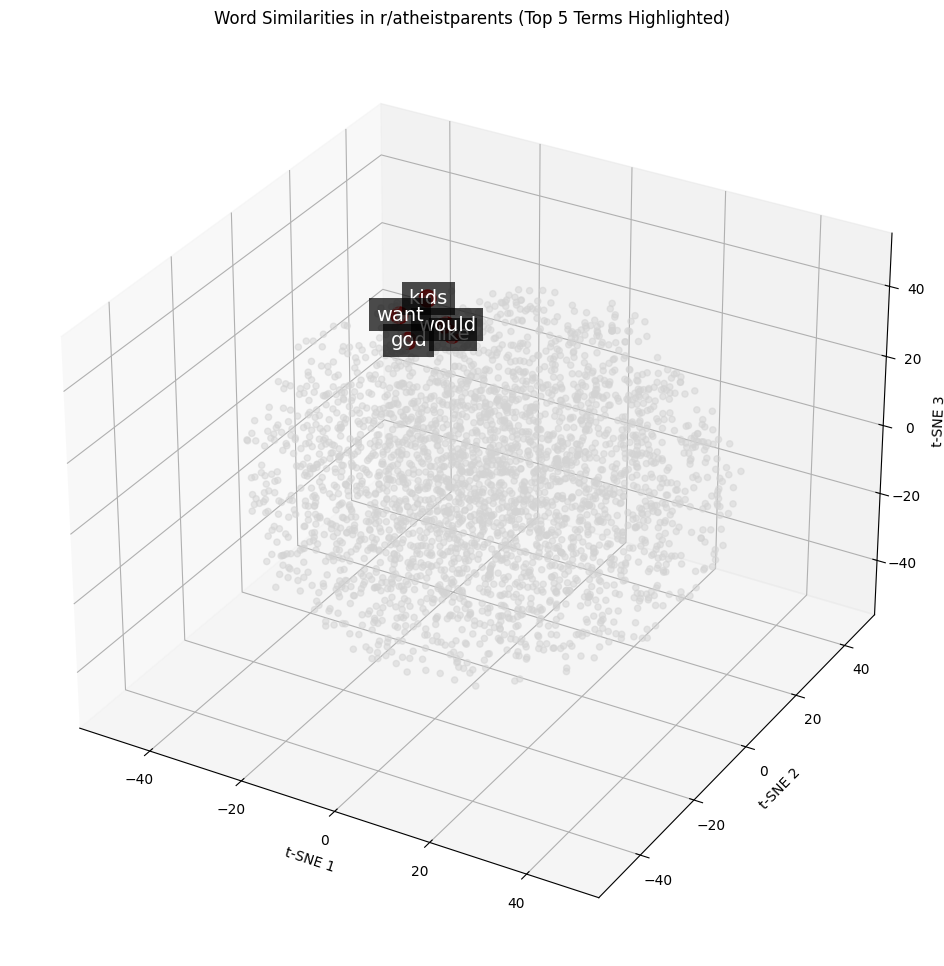

In [4]:
for subreddit, (tfidf_matrix, terms) in subreddit_data.items():
    vis.plot_word_similarities_tsne_3d(
        tfidf_matrix=tfidf_matrix,
        feature_names=terms,
        subreddit=f'r/{subreddit}'
    )

plt.show()

# Embeddings


**Pretrained embeddings:** Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. Download from [this link](https://nlp.stanford.edu/data/glove.840B.300d.zip).


In [5]:
word_vectors = KeyedVectors.load_word2vec_format(
    EMBEDDINGS_DIR / 'glove.840B.300d.txt', binary=False, no_header=True)

In [6]:
# Generate tf-idf matrix
tfidf_matrix, feature_names = nlp.generate_tfidf_matrix(
    posts_df['tokens'].values.tolist())

# Generate word embeddings
word_embeddings = nlp.generate_tfidf_weighted_embeddings(
    tokens=posts_df['tokens'].values.tolist(), tfidf_matrix=tfidf_matrix,
    feature_names=feature_names, word_vectors=word_vectors)
posts_df['weighted_embeddings'] = word_embeddings.tolist()

# Save processed data
posts_df.to_feather(DATA_DIR / 'reddit_religion_combined_embeddings.feather')

Generating weighted embeddings: 100%|██████████| 6776/6776 [00:24<00:00, 274.29it/s]


## Plotting embeddings using t-SNE

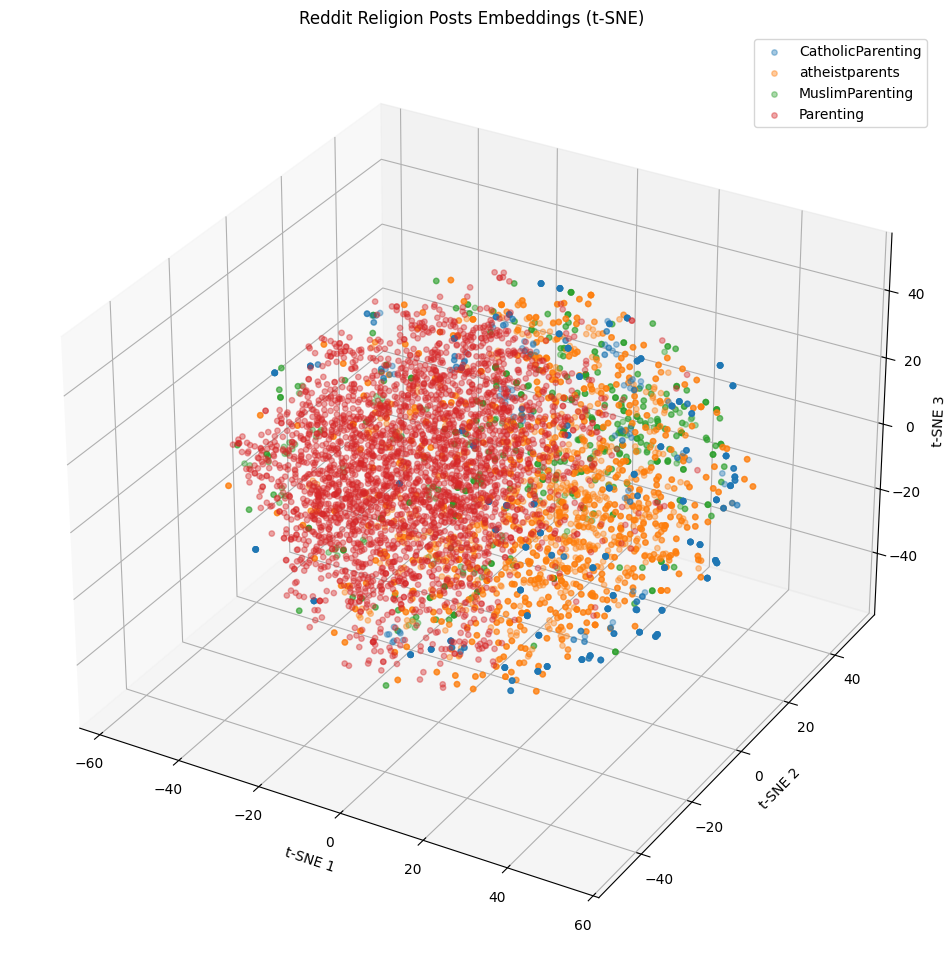

In [7]:
# Load processed data
posts_df = pd.read_feather(
    DATA_DIR / 'reddit_religion_combined_embeddings.feather')

# Plot t-SNE of word embeddings
vis.plot_tsne_3d(
    embeddings=np.vstack(posts_df['weighted_embeddings'].values),
    posts_df=posts_df,
    title='Reddit Religion Posts Embeddings (t-SNE)',
)

plt.show()

## Plotting vector representations of embeddings

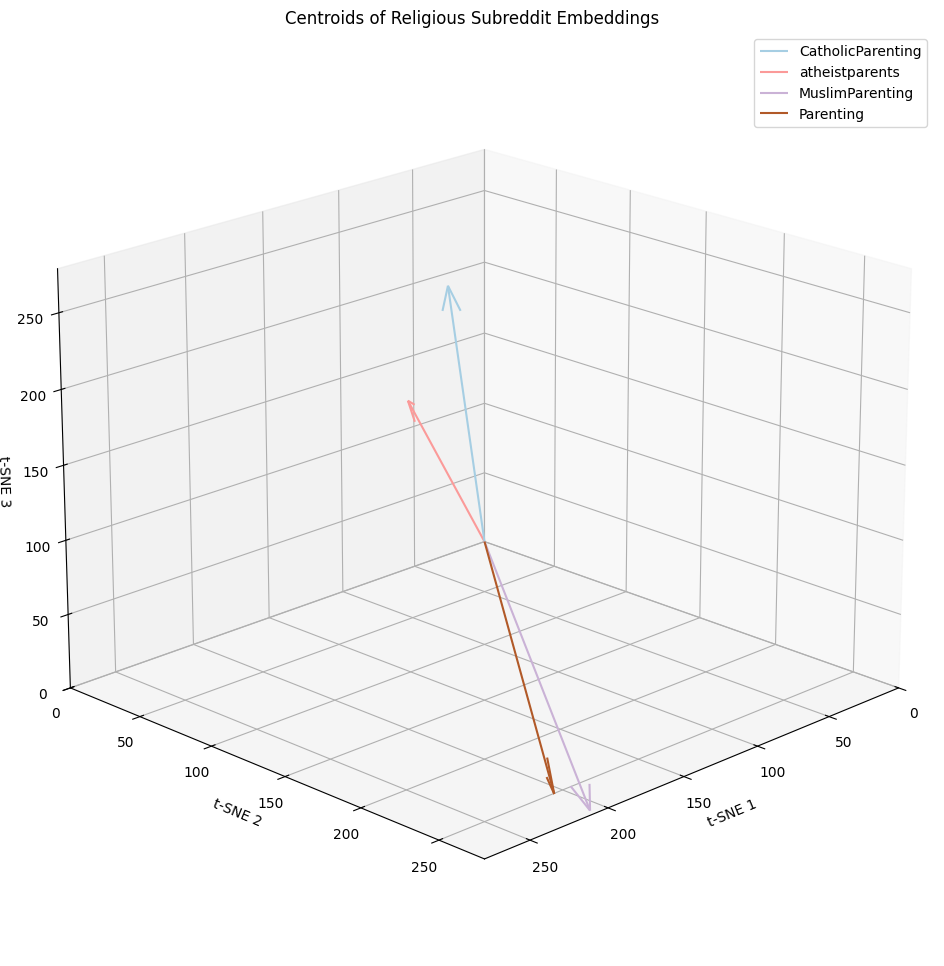

In [8]:
# Load processed data
posts_df = pd.read_feather(
    DATA_DIR / 'reddit_religion_combined_embeddings.feather')

vis.plot_subreddit_vector_space_3d(posts_df=posts_df,
                                   embeddings_column='weighted_embeddings',
                                   title='Centroids of Religious Subreddit Embeddings',
                                   labels=posts_df['subreddit'].unique())

plt.show()